## Project description

Goal is to predict the forest cover type.

### Data Description
Data is raw, including non-scaled data and category data.
* Elevation, quantitative (meters): Elevation in meters 
* Aspect, quantitative (azimuth): Aspect in degrees azimuth 
* Slope, quantitative (degrees): Slope in degrees 
* Horizontal_Distance_To_Hydrology* , quantitative (meters): Horz Dist to nearest surface water features 
* Vertical_Distance_To_Hydrology* , quantitative (meters): Vert Dist to nearest surface water features 
* Horizontal_Distance_To_Roadways* , quantitative (meters ): Horz Dist to nearest roadway 
* Hillshade_9am* , quantitative (0 to 255 index): Hillshade index at 9am, summer solstice 
* Hillshade_Noon*, quantitative (0 to 255 index): Hillshade index at noon, summer soltice
* Hillshade_3pm*, quantitative (0 to 255 index): Hillshade index at 3pm, summer solstice
* Horizontal_Distance_To_Fire_Points*, quantitative (meters): Horz Dist to nearest wildfire ignition points
* Wilderness_Area (4 binary columns)*, qualitative (0 (absence) or 1 (presence)): Wilderness area designation
* Soil_Type (40 binary columns)*, qualitative ( 0 (absence) or 1 (presence)): Soil Type designation
* Cover_Type (7 types)*, integer (1 to 7): Forest Cover Type designation

### Code Designations
***
Wilderness_areas:
* 1 -- Rawah
* 2 -- Neota
* 3 -- Comanche Peak
* 4 -- Cache la Poudre
***
ELU:

First digit : climatic zones
* 1: lower montane dry
* 2: lower montane
* 3: montane dry
* 4: montane
* 5: montane dry and montane
* 6: montane and subalpine
* 7: subalpine
* 8: alpine

Second digit : geologic zones
* 1: alluvium
* 2: glacial
* 3: shale
* 4: sandstone
* 5: mixed sedimentary
* 6: unspecified in the USFS ELU Survey
* 7: igneous and metamorphic
* 8: volcanic

Last two digits : unique to the mapping and have no special meaning
***
Forest Cover Type:
* 1 - Spruce/Fir
* 2 - Lodgepole Pine
* 3 - Ponderosa Pine
* 4 - Cottonwood/Willow
* 5 - Aspen
* 6 - Douglas-fir
* 7 - Krummholz

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import precision_score
import re
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from autogluon.tabular import TabularDataset, TabularPredictor


pd.set_option('display.max_columns', None)

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive"
os.chdir(path)

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('Colab Notebooks/MAP553/train.csv')
df_test_full = pd.read_csv('Colab Notebooks/MAP553/test-full.csv')
#df_submission = pd.read_csv('full_submission.csv')
df_true = pd.read_csv('Colab Notebooks/MAP553/covtype.data',header=None)

df_train_raw = df_train.copy(deep=True)
df_test_full_raw = df_test_full.copy(deep = True)

In [ ]:
# read the data
df_train = pd.read_csv('train.csv')
df_test_full = pd.read_csv('test-full.csv')
df_true = pd.read_csv('covtype.data',header=None)
#df_submission = pd.read_csv('full_submission.csv')

# 1. Data preprocessing

In [ ]:
features = df_train.columns.to_list()
features.remove('Id')
features.remove('Cover_Type')

In [ ]:
# numerical and categorical features
features_num = ['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points']
features_cat = [f for f in features if f not in features_num]

In [ ]:
df_train.isnull().sum()

In [ ]:
for c in df_train.columns:
    print ("---- %s ---" % c)
    print (df_train[c].value_counts())

No null values, and all the data has type int, and we have 15120 different Ids which means no repeated Id

## 1.1 Check for Outliers

In [ ]:
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = (third_quartile - first_quartile)/2
                      
    upper_limit = third_quartile+(6*IQR)
    lower_limit = first_quartile-(6*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [ ]:
for column in features_num:
    if outlier_function(df_train, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(df_train, column)[2], column))

There are 33 outliers in Horizontal_Distance_To_Hydrology
There are 51 outliers in Vertical_Distance_To_Hydrology
There are 10 outliers in Hillshade_9am
There are 15 outliers in Hillshade_Noon
There are 158 outliers in Horizontal_Distance_To_Fire_Points


In [ ]:
# remove outliers
df_train = df_train[(df_train['Horizontal_Distance_To_Fire_Points'] > outlier_function(df_train, 'Horizontal_Distance_To_Fire_Points')[0]) &
              (df_train['Horizontal_Distance_To_Fire_Points'] < outlier_function(df_train, 'Horizontal_Distance_To_Fire_Points')[1])]
df_train.shape

(14962, 56)

## 1.2 Distibution of trees

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Trees/Labels/Cover_Types')

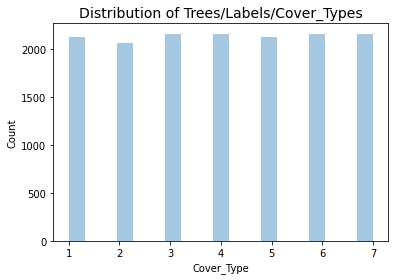

In [ ]:
sns.distplot(df_train["Cover_Type"], kde=False)
plt.xlabel("Cover_Type")
plt.ylabel("Count")
plt.title("Distribution of Trees/Labels/Cover_Types", size=14)
#plt.savefig('./images/count.png')

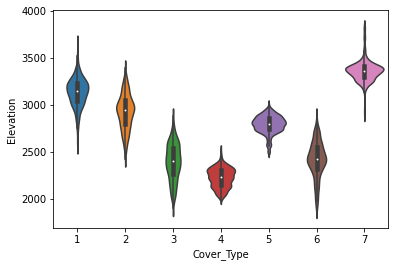

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Elevation', data=df_train[['Cover_Type','Elevation']])
#plt.savefig('./images/Elevation_Cover_Type.png')

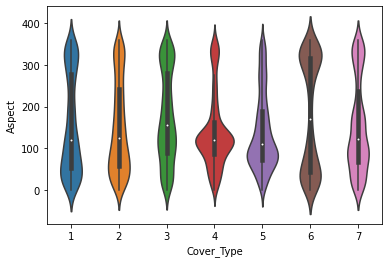

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Aspect', data=df_train[['Cover_Type','Aspect']])
#plt.savefig('./images/Aspect_Cover_Type.png')

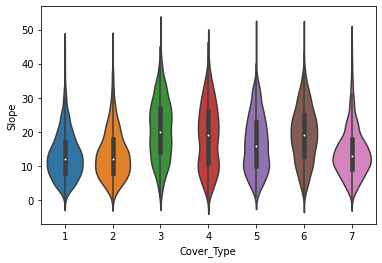

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Slope', data=df_train[['Cover_Type','Slope']])
#plt.savefig('./images/Slope_Cover_Type.png')

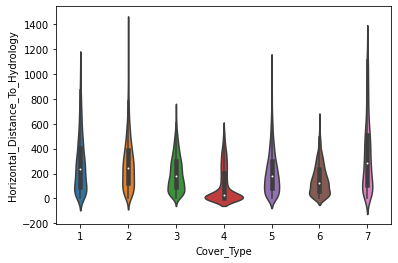

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Horizontal_Distance_To_Hydrology', data=df_train[['Cover_Type','Horizontal_Distance_To_Hydrology']])
#plt.savefig('./images/Horizontal_Distance_To_Hydrology_Cover_Type.png')

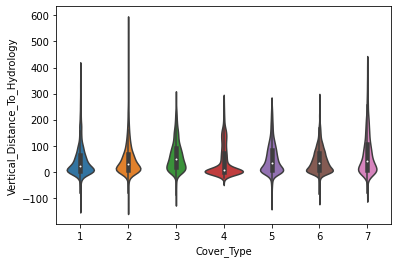

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Vertical_Distance_To_Hydrology', data=df_train[['Cover_Type','Vertical_Distance_To_Hydrology']])
#plt.savefig('./images/Vertical_Distance_To_Hydrology_Cover_Type.png')

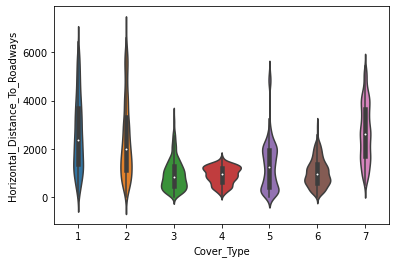

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Horizontal_Distance_To_Roadways', data=df_train[['Cover_Type','Horizontal_Distance_To_Roadways']])
#plt.savefig('./images/Horizontal_Distance_To_Roadways_Cover_Type.png')

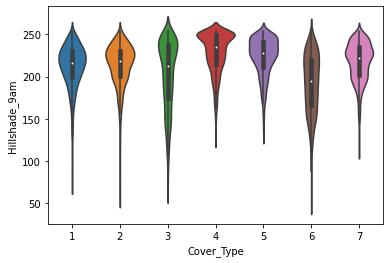

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Hillshade_9am', data=df_train[['Cover_Type','Hillshade_9am']])
#plt.savefig('./images/Hillshade_9am_Cover_Type.png')

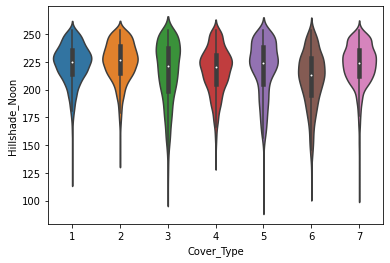

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Hillshade_Noon', data=df_train[['Cover_Type','Hillshade_Noon']])
#plt.savefig('./images/Hillshade_Noon_Cover_Type.png')

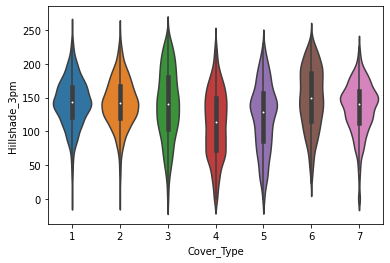

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Hillshade_3pm', data=df_train[['Cover_Type','Hillshade_3pm']])
#plt.savefig('./images/Hillshade_3pm_Cover_Type.png')

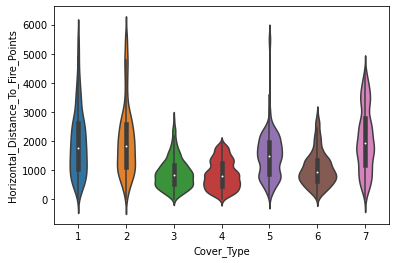

In [ ]:
sns.violinplot(x = 'Cover_Type', y='Horizontal_Distance_To_Fire_Points', data=df_train[['Cover_Type','Horizontal_Distance_To_Fire_Points']])
#plt.savefig('./images/Horizontal_Distance_To_Fire_Points_Cover_Type.png')

## 1.3 Distribution and relationship between numerical features

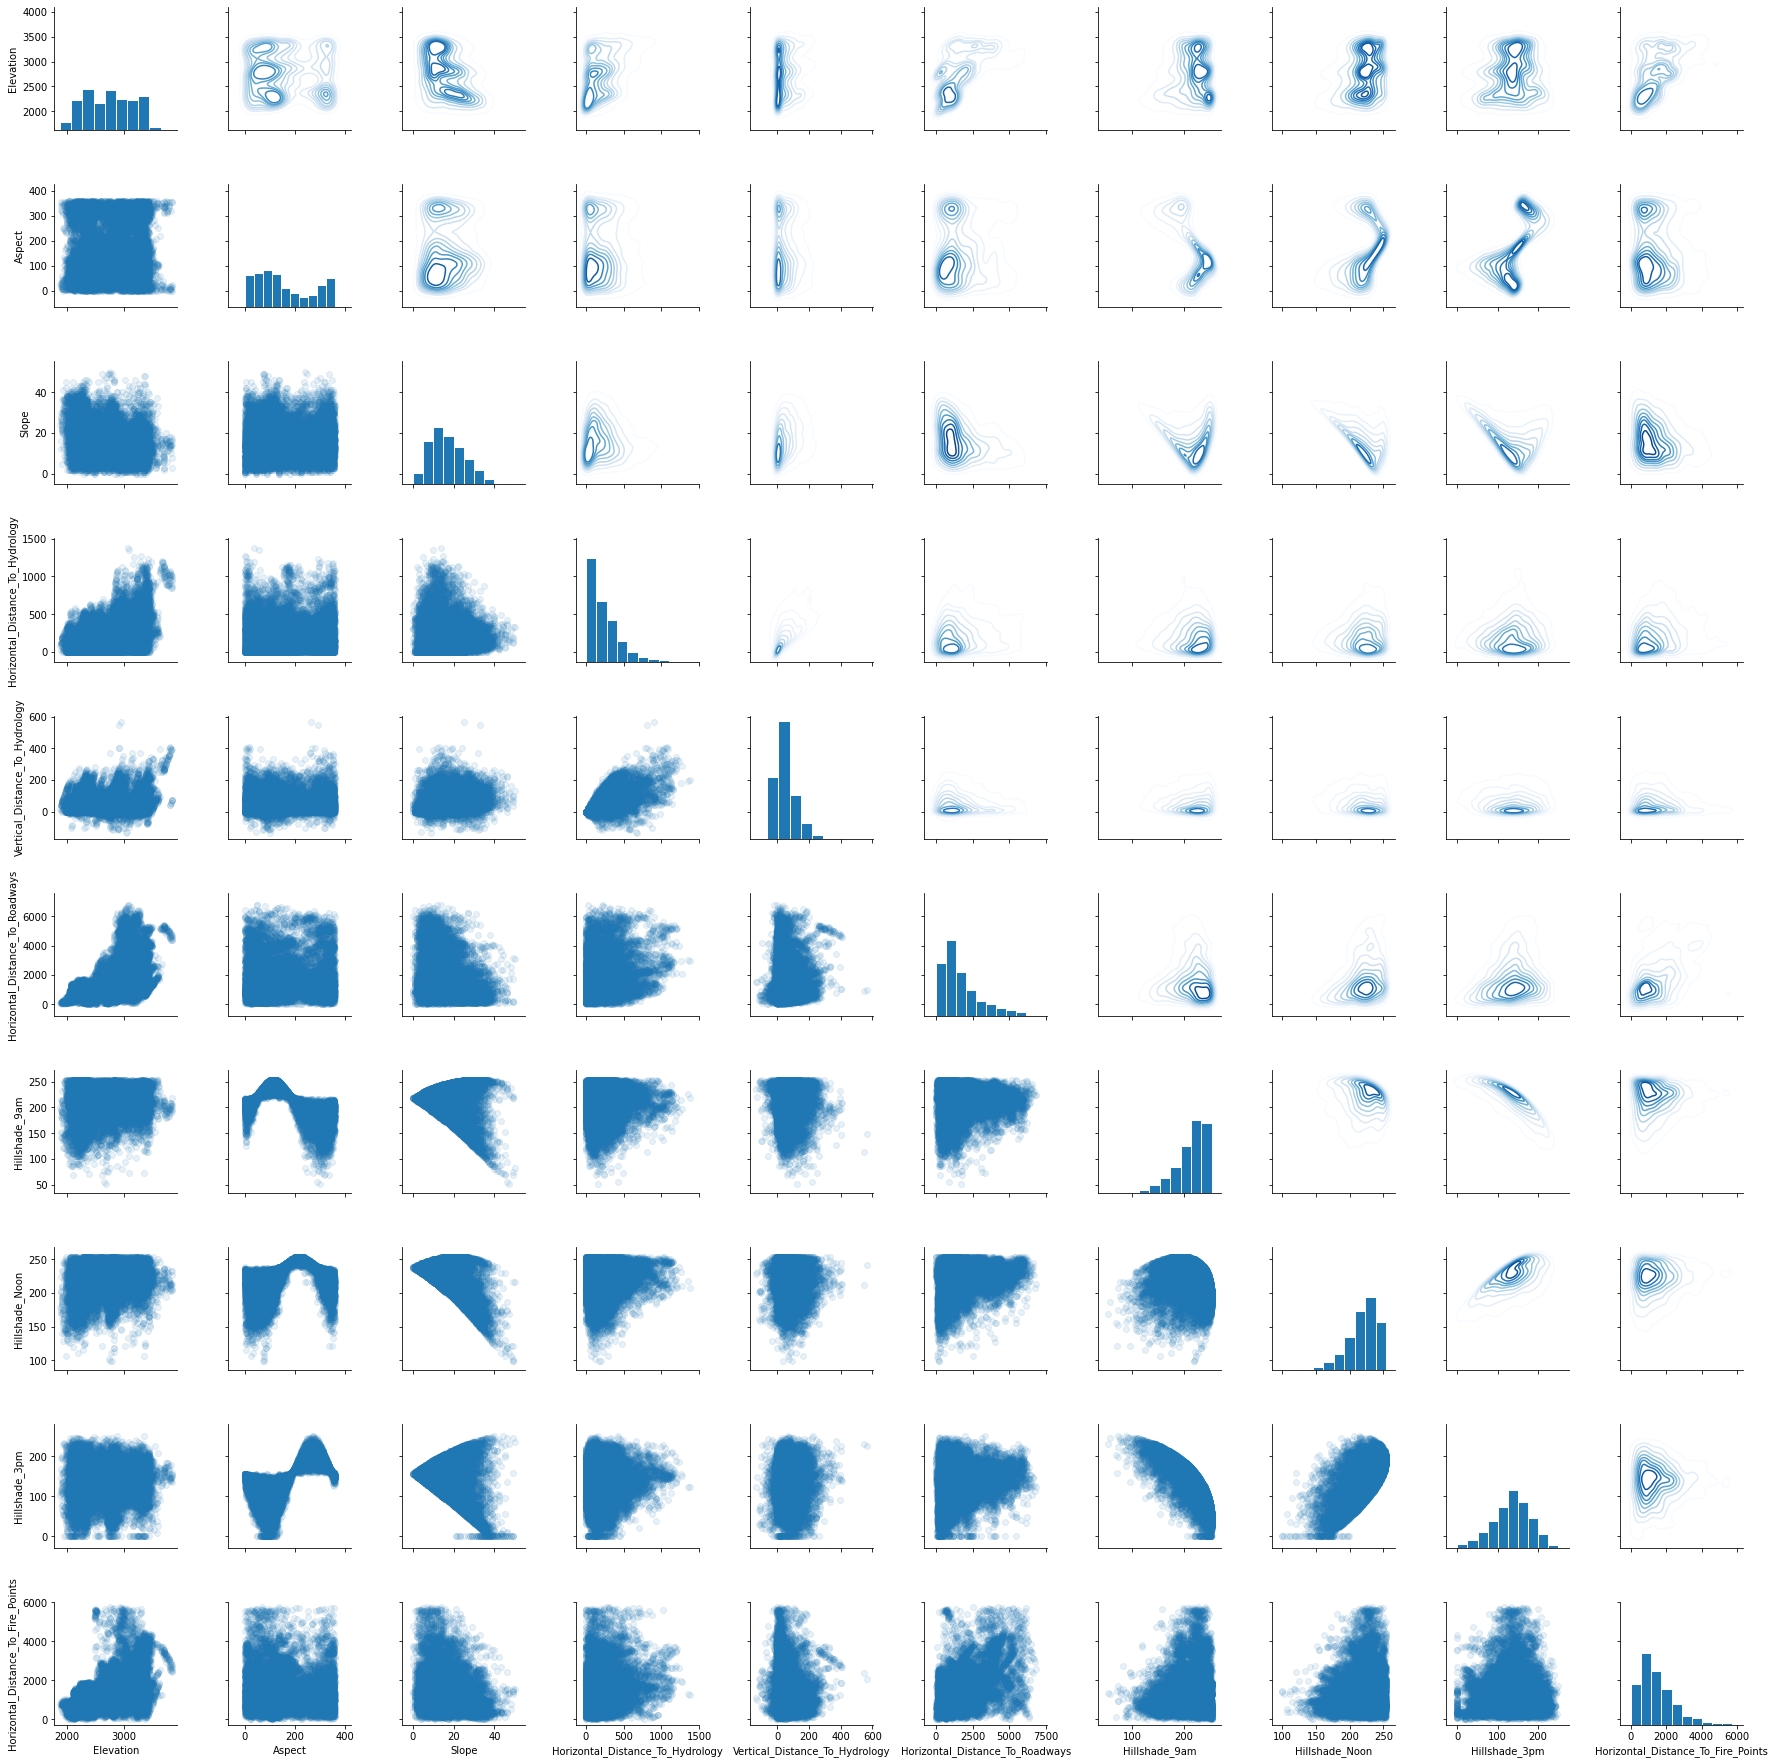

In [ ]:
# Create the pairgrid object
grid = sns.PairGrid(data = df_train[features_num])

# Upper is a correlation and kdeplot
grid.map_upper(sns.kdeplot, cmap = plt.cm.Blues)

# Diagonal is a histogram
grid.map_diag(plt.hist, edgecolor = 'white')

# Bottom is scatter plot
grid.map_lower(plt.scatter, alpha = 0.1)

## 1.4 Pearson correaltion between features

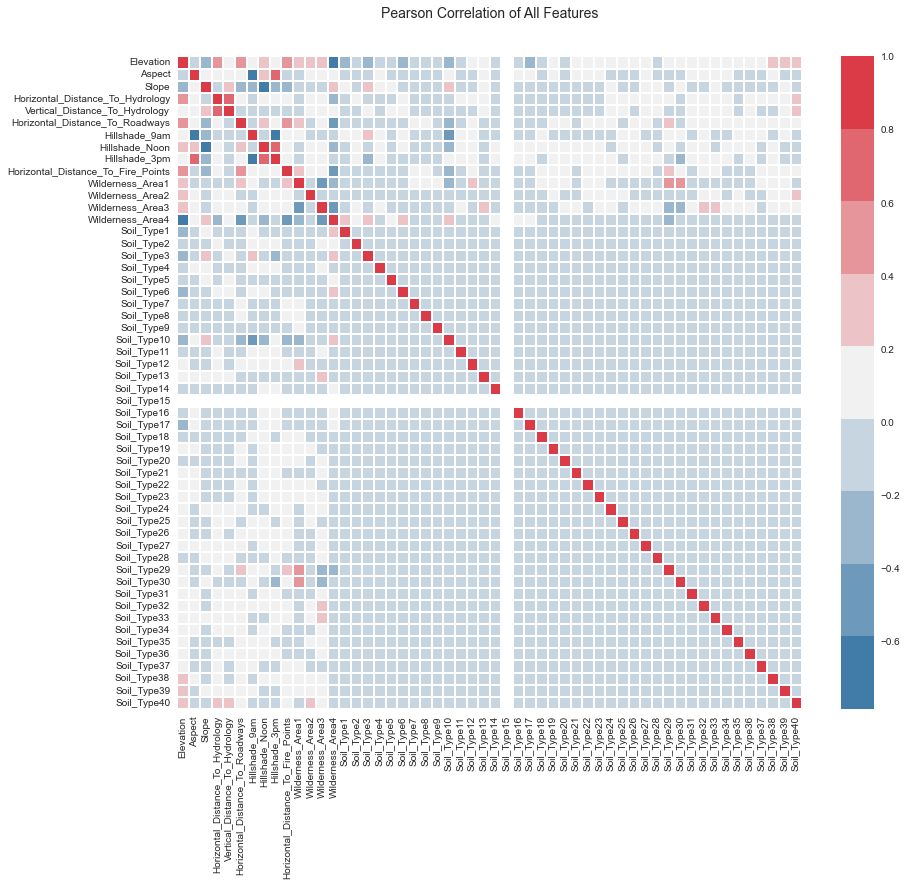

In [ ]:
plt.figure(figsize=(14,12))

# plot heatmap set the title
colormap = sns.diverging_palette(240, 10, n=9)
sns.heatmap(df_train[features].corr(),linewidths=0.1,vmax=1.0, 
            square=False, cmap = colormap,linecolor='white', annot=False)
plt.title('Pearson Correlation of All Features', y=1.05, size=14)
# plt.savefig('./images/pearson.png')

## 1.5 Relationship between each categorical feature and cover type

In [ ]:
for index, row in df_train.iloc[:,11:-1].iteritems():
    table = pd.crosstab(df_train[index],df_train["Cover_Type"])
    table.div(table.sum(1).astype(float),axis = 0).plot(kind = "bar",stacked = True)
    #plt.title(index)
    plt.xlabel(index)
    plt.ylabel("proportion")
    plt.show()

# 2. Features Engineering and selection

## 2.1 Extract information from ELU

In [ ]:
# to get the climate and geologic information from the raw data
SolidType = '''1: ELU 2702, Cathedral family - Rock outcrop complex, extremely stony.
2: ELU 2703, Vanet - Ratake families complex, very stony.
3: ELU 2704, Haploborolis - Rock outcrop complex, rubbly.
4: ELU 2705, Ratake family - Rock outcrop complex, rubbly.
5: ELU 2706, Vanet family - Rock outcrop complex complex, rubbly.
6: ELU 2717, Vanet - Wetmore families - Rock outcrop complex, stony.
7: ELU 3501, Gothic family.
8: ELU 3502, Supervisor - Limber families complex.
9: ELU 4201, Troutville family, very stony.
10: ELU 4703, Bullwark - Catamount families - Rock outcrop complex, rubbly.
11: ELU 4704, Bullwark - Catamount families - Rock land complex, rubbly.
12: ELU 4744, Legault family - Rock land complex, stony.
13: ELU 4758, Catamount family - Rock land - Bullwark family complex, rubbly.
14: ELU 5101, Pachic Argiborolis - Aquolis complex.
15: ELU 5151, unspecified in the USFS Soil and ELU Survey.
16: ELU 6101, Cryaquolis - Cryoborolis complex.
17: ELU 6102, Gateview family - Cryaquolis complex.
18: ELU 6731, Rogert family, very stony.
19: ELU 7101, Typic Cryaquolis - Borohemists complex.
20: ELU 7102, Typic Cryaquepts - Typic Cryaquolls complex.
21: ELU 7103, Typic Cryaquolls - Leighcan family, till substratum complex.
22: ELU 7201, Leighcan family, till substratum, extremely bouldery.
23: ELU 7202, Leighcan family, till substratum - Typic Cryaquolls complex.
24: ELU 7700, Leighcan family, extremely stony.
25: ELU 7701, Leighcan family, warm, extremely stony.
26: ELU 7702, Granile - Catamount families complex, very stony.
27: ELU 7709, Leighcan family, warm - Rock outcrop complex, extremely stony.
28: ELU 7710, Leighcan family - Rock outcrop complex, extremely stony.
29: ELU 7745, Como - Legault families complex, extremely stony.
30: ELU 7746, Como family - Rock land - Legault family complex, extremely stony.
31: ELU 7755, Leighcan - Catamount families complex, extremely stony.
32: ELU 7756, Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
33: ELU 7757, Leighcan - Catamount families - Rock outcrop complex, extremely stony.
34: ELU 7790, Cryorthents - Rock land complex, extremely stony.
35: ELU 8703, Cryumbrepts - Rock outcrop - Cryaquepts complex.
36: ELU 8707, Bross family - Rock land - Cryumbrepts complex, extremely stony.
37: ELU 8708, Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
38: ELU 8771, Leighcan - Moran families - Cryaquolls complex, extremely stony.
39: ELU 8772, Moran family - Cryorthents - Leighcan family complex, extremely stony.
40: ELU 8776, Moran family - Cryorthents - Rock land complex, extremely stony.'''
SolidType = SolidType.split('\n')
ELU = [re.findall(r'\d{4}',string)[0] for string in SolidType]
def get_elu(_data):
    
    data = _data.copy(deep=True)
    data['Soil_Type'] = data.iloc[:,15:55].apply(lambda x : x.to_list().index(1),axis=1)

    data['Climate'] = [int(ELU[x])//1000 for x in data.Soil_Type]

    data['Geology'] = [int(ELU[x])//100 for x in data.Soil_Type]
    data['Geology'] = data['Geology'] - data['Climate']*10
    
    return data

def get_wild(_data):
    
    data = _data.copy(deep=True)
    data['Wilderness_Area'] = data.iloc[:,11:15].apply(lambda x : x.to_list().index(1),axis=1)
    
    return data

## 2.2 One-hot encoder

In [ ]:
# OneHotEncoder
# def encode_onehot(_data):
    
#     data = _data.copy(deep=True)
#     enc_onehot = preprocessing.OneHotEncoder(dtype=np.int32)
#     onehot_features = ['Climate','Geology']
#     enc_onehot.fit(data[onehot_features])
#     after_onehot_features = enc_onehot.get_feature_names(onehot_features)
#     data_onehot = pd.DataFrame(enc_onehot.transform(data[onehot_features]).toarray(),columns=after_onehot_features)
#     data.drop(onehot_features,axis=1,inplace=True)
#     data = data.join(data_onehot)
#     data.drop('Soil_Type',axis=1,inplace=True)
    
#     return data

def encode_onehot(_data):
    
    data = _data.copy(deep=True)
    onehot_features = ['Climate','Geology']
    for f in onehot_features:
        data_onehot = pd.get_dummies(data[f],prefix=f)
        #data.drop(f,axis=1,inplace=True)
        data = data.join(data_onehot)
    return data

## 2.3 Transform features

In [ ]:
def feature_engineering(_data):
    
    data = _data.copy(deep=True)
    
    data['Ele_minus_VDtHyd'] = data['Elevation']-data['Vertical_Distance_To_Hydrology']
    
    data['Ele_plus_VDtHyd'] = data['Elevation']+data['Vertical_Distance_To_Hydrology']
    
    data['Distanse_to_Hydrolody'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5
    
    data['Slope_angle'] = np.arctan(data['Slope'])
    
    data['Aspect_sin'] = np.sin(data['Aspect']*np.pi/180)
    
    data['Aspect_cos'] = np.cos(data['Aspect']*np.pi/180)
    
    data['Hydro_plus_Fire'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Fire_Points']
     
    data['Hydro_minus_Fire'] = data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Fire_Points']
     
    data['Hydro_plus_Road'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Roadways']
     
    data['Hydro_minus_Road'] = data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Roadways']
     
    data['Fire_plus_Road'] = data['Horizontal_Distance_To_Fire_Points']+data['Horizontal_Distance_To_Roadways']
     
    data['Fire_minus_Road'] = data['Horizontal_Distance_To_Fire_Points']-data['Horizontal_Distance_To_Roadways']
    
    data['binned_elevation'] = [np.floor(v/50.0) for v in data['Elevation']]
    
    data['Horizontal_Distance_To_Roadways_Log'] = np.log(data['Horizontal_Distance_To_Roadways']+1)
    
    data['Soil_Type12_32'] = data['Soil_Type32'] + data['Soil_Type12']
    
    data['Soil_Type23_22_32_33'] = data['Soil_Type23'] + data['Soil_Type22'] + data['Soil_Type32'] + data['Soil_Type33']
    
    data['r_VH_Hydrology'] = data['Vertical_Distance_To_Hydrology'] / data['Horizontal_Distance_To_Hydrology']
    data['r_VH_Hydrology']= data['r_VH_Hydrology'].map(lambda x: 0 if np.isnan(x) else x)
    data['r_VH_Hydrology']= data['r_VH_Hydrology'].map(lambda x: 0 if np.isinf(x) else x)
    
    data['Elev_to_HD_Hyd']=data['Elevation'] - 0.2 * data['Horizontal_Distance_To_Hydrology']
    
    data['Elev_to_HD_Road']=data['Elevation'] - 0.05 * data['Horizontal_Distance_To_Roadways']
    
    data['Mean_Amenities']=(data['Horizontal_Distance_To_Fire_Points'] + data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Roadways']) / 3
    
    data['Mean_Fire_Hyd']=(data['Horizontal_Distance_To_Fire_Points'] + data['Horizontal_Distance_To_Hydrology']) / 2
    
    data['is_water_below'] = data['Vertical_Distance_To_Hydrology']<0
    
    return data

def get_features(_data):
    
    features = _data.columns.to_list()
    features.remove('Id')
    features.remove('Cover_Type')
    
    features_num = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
                    'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
                    'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
    features_num = features_num + ['Ele_minus_VDtHyd','Ele_plus_VDtHyd','Distanse_to_Hydrolody','Slope_angle','Aspect_sin','Aspect_cos',
                                   'Hydro_plus_Fire','Hydro_minus_Fire','Hydro_plus_Road','Hydro_minus_Road','Fire_plus_Road','Fire_minus_Road',
                                  'binned_elevation','Horizontal_Distance_To_Roadways_Log','Soil_Type','Wilderness_Area','Climate','Geology',
                                  'r_VH_Hydrology','Elev_to_HD_Hyd','Elev_to_HD_Road','Mean_Amenities','Mean_Fire_Hyd']
    features_cat = [f for f in features if f not in features_num]
    
    return features,features_num,features_cat

In [ ]:
# for plot ROC curve
def roc_curve(valid,pred, path,save = True):
    
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    from itertools import cycle

    n_classes = 7

    y_valid = label_binarize(valid, classes=[1,2,3,4,5,6,7])
    y_valid_pred = label_binarize(pred, classes=[1,2,3,4,5,6,7])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], y_valid_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area（方法二）
    fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), y_valid_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area（方法一）
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw=1
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2)

    colors = cycle(['purple','green','blue','pink','brown','red','turquoise'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve on validation set')
    plt.legend(loc="lower right")
    if save:
        plt.savefig(path)
    plt.show()

In [ ]:
df_train = get_elu(df_train)
df_train = get_wild(df_train)
df_train = encode_onehot(df_train)
df_train = feature_engineering(df_train)

In [ ]:
df_test_full = get_elu(df_test_full)
df_test_full = get_wild(df_test_full)
df_test_full = encode_onehot(df_test_full)
df_test_full = feature_engineering(df_test_full)

In [ ]:
features, features_num,features_cat = get_features(df_train)

## Split data

In [ ]:
# remove some features
features = list(set(features).difference(set(['Soil_Type1','Soil_Type2', 'Soil_Type3', 'Soil_Type4', 
                                              'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
                                              'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
                                              'Soil_Type13', 'Soil_Type14', 'Soil_Type15',
                                              'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
                                              'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
                                              'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
                                              'Soil_Type27', 'Soil_Type28', 'Soil_Type29',
                                              'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33',
                                              'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
                                              'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'])))
features = list(set(features).difference(set(['Climate_8','Climate_5','Climate_3','Climate_6','Climate_7',
                                              'Climate_4','Climate_2'])))
features = list(set(features).difference(set(['Geology_2','Geology_5','Geology_7','Geology_1'])))
features = features +['Id']

In [ ]:
data = df_train[features]
target = df_train['Cover_Type']
X_train, X_valid, Y_train, Y_valid = train_test_split(data, target, train_size=0.8, 
                                                      test_size=0.2, random_state=5, stratify = target)

## Baseline

In [ ]:
from sklearn.dummy import DummyClassifier
# Create dummy classifer
dummy = DummyClassifier(strategy='stratified', random_state=1)

# train the model
dummy.fit(X_train, Y_train)

# Get accuracy score
baseline_accuracy = dummy.score(X_valid, Y_valid)
print("Our dummy algorithm classified {:0.2f} of the of the trees correctly.".format(baseline_accuracy))

Our dummy algorithm classified 0.14 of the of the trees correctly.


## 3.1 Logistic regression

In [ ]:
model_LR = LogisticRegression(solver='lbfgs')
model_LR.fit(X_train,Y_train)

In [ ]:
pred_valid_lr = model_LR.predict(X_valid)
print('Accuracy score on validation set is: ',metrics.accuracy_score(Y_valid, pred_valid_lr))

## 3.2 XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=20,objective ='multi:softprob', num_class = 7, eval_metric= 'merror',
                   verbose = False)

params_xgb = {'n_estimators':[100,110,120,130],
          'max_depth':[6,7,8],
          'learning_rate':[0.1]}


#skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
gsearch_xgb = GridSearchCV(estimator=xgb,param_grid=params_xgb,n_jobs=-1,cv=3,verbose=1,scoring='accuracy')

gsearch_xgb.fit(X_train, Y_train)
parameters_xgb = gsearch_xgb.best_params_
pred_valid_xgb = gsearch_xgb.predict(X_valid)
#pred_test_xgb = gsearch_xgb.predict(df_test_full[features])
pred_train_xgb = gsearch_xgb.predict(X_train)

print('Accuracy score on validation set is: ',metrics.accuracy_score(Y_valid, pred_valid_xgb))

In [ ]:
parameters_xgb

In [ ]:
#roc_curve(Y_train,pred_train_xgb,path='./images/roc_train_xgb.png',save=False)
#roc_curve(Y_valid,pred_valid_xgb,path='./images/roc_valid_xgb.png',save=False)

## 3.3 Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
params = {'n_estimators':[90,100,150],
          'criterion':['gini','entropy'],
          'max_features':['sqrt','log2'],
          'min_samples_split':[2,3,5],
          'min_samples_leaf':[1,2]}

etc = ExtraTreesClassifier(random_state = 20, n_jobs = -1)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
gsearch_etc = GridSearchCV(etc,params,n_jobs=-1,cv=skf,verbose=1)

gsearch_etc.fit(X_train, Y_train)
best_parameters = gsearch_etc.best_params_
best_etc = gsearch_etc.best_estimator_
pred_valid_etc = gsearch_etc.predict(X_valid)
pred_test_etc = gsearch_etc.predict(df_test_full[features])
pred_train_etc = gsearch_etc.predict(X_train)

print('Accuracy score on validation set is: ',metrics.accuracy_score(Y_valid, pred_valid_etc))

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  3.5min finished


Accuracy score on validation set is:  0.9144670898763783


In [ ]:
print(gsearch_etc.best_params_)

{'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


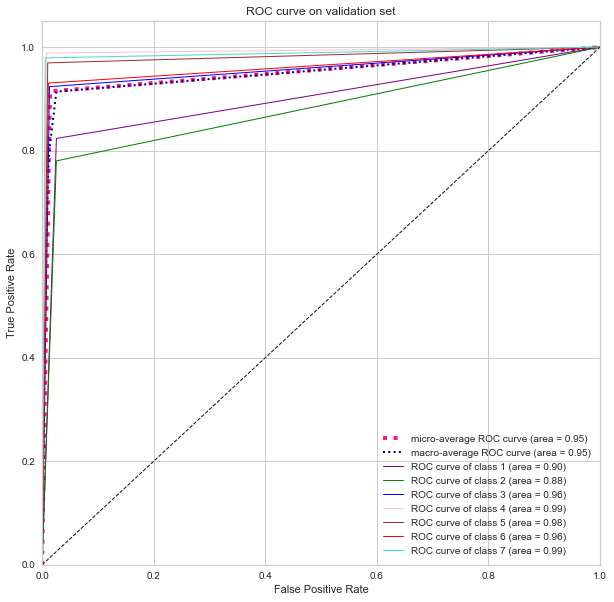

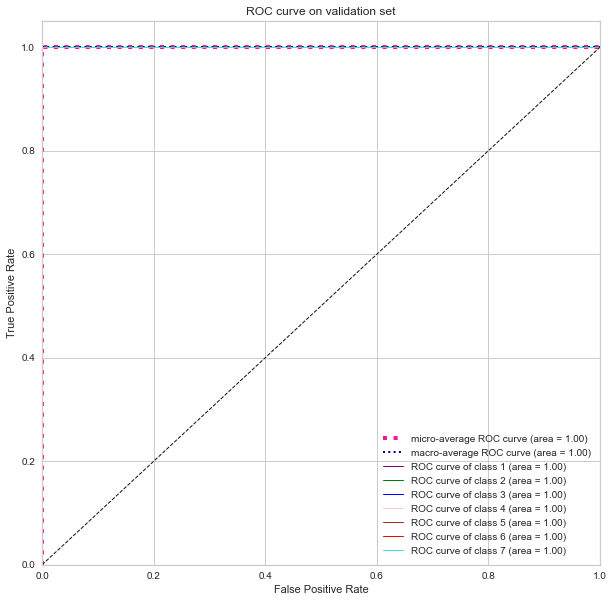

In [ ]:
roc_curve(Y_valid,pred_valid_etc,path='./images/roc_valid.png',save=False)
roc_curve(Y_train,pred_train_etc,path='./images/roc_train.png',save=False)

### Feature Importance

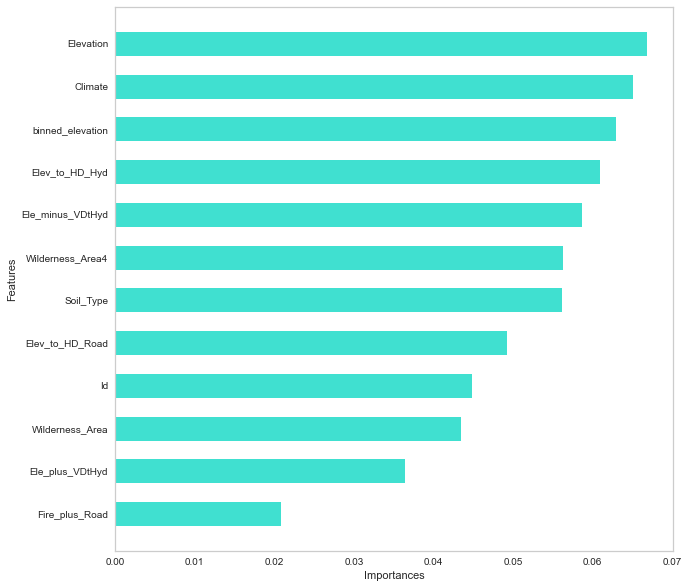

In [ ]:
Feature_importances = [round(x,4) for x in best_etc.feature_importances_]
F2 = pd.Series(Feature_importances,index = features)
F2 = F2.sort_values(ascending = True)
F2 = F2[F2>=0.02]
f_index = F2.index
f_values = F2.values

x_index = list(range(0,12))
x_index = [x/20 for x in x_index]
#plt.rcParams['figure.figsize'] = (10,10)
plt.barh(x_index,f_values,height = 0.028 ,color = 'turquoise',tick_label=f_index)
plt.grid(False)
plt.xlabel('Importances')
plt.ylabel('Features')
#plt.savefig('./images/features_importance_etc.png')
plt.show()

## 3.4 RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier(random_state = 20, n_jobs = -1, n_estimators = 100, bootstrap = True, max_depth = 50,
#                             max_features = 0.5)
# rfc.fit(X_train, Y_train)

# pred_valid_rf = rfc.predict(X_valid)
# pred_test_rf = rfc.predict(df_test_full[features])

params = {'n_estimators':[100,150],
          'criterion':['gini', 'entropy'],
          'max_depth':[15,30,50],
          'max_features':['sqrt','auto','log2'],
          'min_samples_split':[2,3],
          'min_samples_leaf':[1,2]}

rfc = RandomForestClassifier(random_state = 20, n_jobs = -1, bootstrap = True)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
gsearch_rfc = GridSearchCV(rfc,params,n_jobs=-1,cv=skf,verbose=1)

gsearch_rfc.fit(X_train, Y_train)
parameters = gsearch_rfc.best_params_
pred_valid_rfc = gsearch_rfc.predict(X_valid)
pred_test_rfc = gsearch_rfc.predict(df_test_full[features])
pred_train_rfc = gsearch_etc.predict(X_train)

print('Accuracy score on validation set is: ',metrics.accuracy_score(Y_valid, pred_valid_rfc))

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 19.8min finished


Accuracy score on validation set is:  0.9041095890410958


In [ ]:
parameters

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

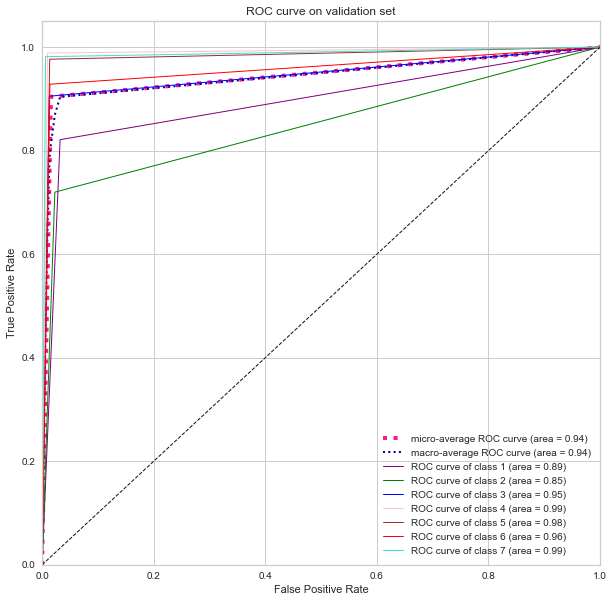

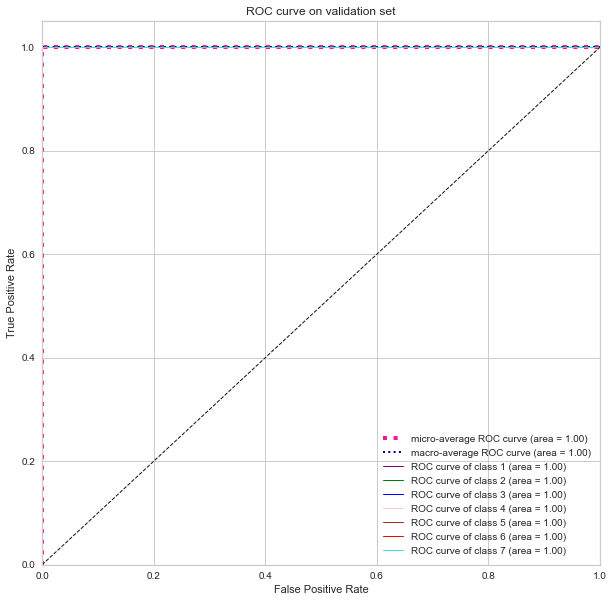

In [ ]:
roc_curve(Y_valid,pred_valid_rfc,path='./images/roc_valid_rfc.png',save=False)
roc_curve(Y_train,pred_train_rfc,path='./images/roc_train_rfc.png',save=False)

## AutoGluon

In [ ]:
train_data = df_train.copy(deep=True)
#train_data = TabularDataset('Colab Notebooks/MAP553/train.csv')

ide, label = 'Id','Cover_Type'

# if we want to get the complete model, uncomment this line
# predictor = TabularPredictor(label=label).fit(train_data[features+['Cover_Type']],
#                                                 presets =['good_quality_faster_inference_only_refit', 'optimize_for_deployment'])

predictor = TabularPredictor(label=label).fit(train_data[features+['Cover_Type']])

No path specified. Models will be saved in: "AutogluonModels/ag-20220104_220240/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220104_220240/"
AutoGluon Version:  0.3.1
Train Data Rows:    14962
Train Data Columns: 41
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	7 unique label values:  [1, 2, 3, 4, 5, 6, 7]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 7
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11883.83 MB
	Train Data (Original)  Memory Usage: 4.8 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify

[1000]	train_set's multi_error: 0	valid_set's multi_error: 0.0955244


	0.9092	 = Validation score   (accuracy)
	54.65s	 = Training   runtime
	1.43s	 = Validation runtime
Fitting model: LightGBM ...
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	0.9092	 = Validation score   (accuracy)
	21.2s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.8864	 = Validation score   (accuracy)
	10.81s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.8891	 = Validation score   (accuracy)
	20.48s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: CatBoost ...
	0.8771	 = Validation score   (accuracy)
	88.11s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ..

In [ ]:
# evaluate the performance of each individual trained model on test data
ldboard = predictor.leaderboard(train_data[features+['Cover_Type']])

                  model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2    0.991512   0.915164       35.500392       4.455915  407.206903                 0.022567                0.000753           0.749733            2       True         14
1              LightGBM    0.990910   0.909152        2.689781       0.394166   21.195446                 2.689781                0.394166          21.195446            1       True          5
2            LightGBMXT    0.990910   0.909152        9.646699       1.431661   54.652478                 9.646699                1.431661          54.652478            1       True          4
3               XGBoost    0.990777   0.907816        2.818585       0.236684   62.686421                 2.818585                0.236684          62.686421            1       True         11
4         LightGBMLarge    0.990376

In [ ]:
# prediction
y_pred = predictor.predict(df_test_full[features])

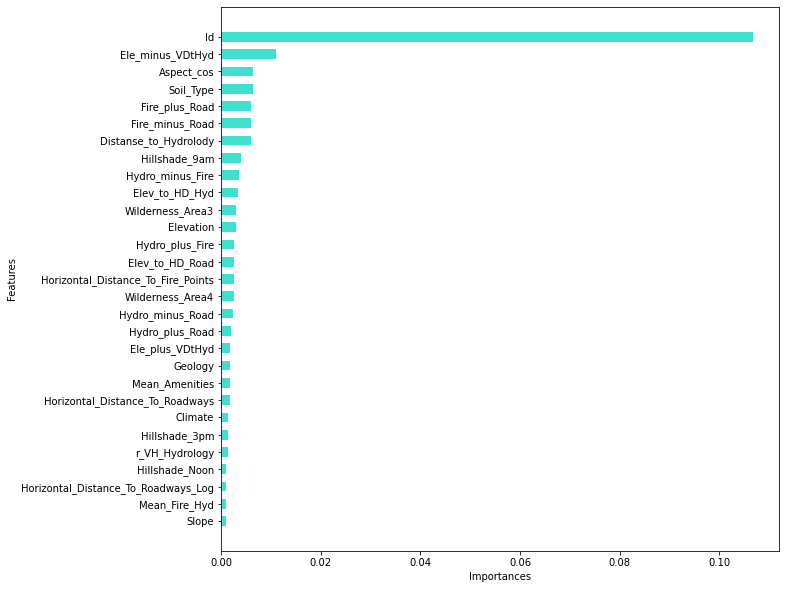

In [ ]:
# plotting feature importance
f_importance = predictor.feature_importance(train_data[features+['Cover_Type']])
F2 = f_importance['importance']
F2 = F2.sort_values(ascending = True)
F2 = F2[F2>=0.001]
f_index = F2.index
f_values = F2.values

x_index = list(range(0,len(F2)))
x_index = [x/20 for x in x_index]
plt.rcParams['figure.figsize'] = (10,10)
plt.barh(x_index,f_values,height = 0.028 ,align="center",color = 'turquoise',tick_label=f_index)
plt.xlabel('Importances')
plt.ylabel('Features')
#plt.savefig('Colab Notebooks/MAP553/f_importance_ag.png')
plt.show()

## Output

In [ ]:
df_test_full.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Distanse_to_Hydrolody,Slope_angle,Aspect_sin,Aspect_cos,Hydro_plus_Fire,Hydro_minus_Fire,Hydro_plus_Road,Hydro_minus_Road,Fire_plus_Road,Fire_minus_Road
0,1,2596,51,3,258,0,510,221,232,148,...,258.000000,1.249046,0.777146,0.629320,6537,-6021,768,-252,6789,5769
1,2,2590,56,2,212,-6,390,220,235,151,...,212.084889,1.107149,0.829038,0.559193,6437,-6013,602,-178,6615,5835
2,3,2804,139,9,268,65,3180,234,238,135,...,275.769832,1.460139,0.656059,-0.754710,6389,-5853,3448,-2912,9301,2941
3,4,2785,155,18,242,118,3090,238,238,122,...,269.235956,1.515298,0.422618,-0.906308,6453,-5969,3332,-2848,9301,3121
4,5,2595,45,2,153,-1,391,220,234,150,...,153.003268,1.107149,0.707107,0.707107,6325,-6019,544,-238,6563,5781


In [ ]:
df_et = pd.DataFrame(df_test_full['Id'])
df_et['Cover_Type'] = pred_test_etc

df_rf = pd.DataFrame(df_test_full['Id'])
df_rf['Cover_Type'] = pred_test_rfc

df_ag = pd.DataFrame(df_test_full['Id'])
df_ag['Cover_Type'] = y_pred